# Generate distance-dependent motion-related artifact plots
The rank for the intercept (smoothing curve at 35mm) indexes general dependence on motion (i.e., a mix of global and focal effects), while the rank for the slope (difference in smoothing curve at 100mm and 35mm) indexes distance dependence (i.e., focal effects).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nibabel as nib
import pandas as pd
from nilearn import datasets

import generate_plots as gp

sns.set_style('whitegrid')

In [2]:
n_subjects = 31
fd_thresh = 0.1
window = 1000
v1, v2 = 35, 100  # distances to evaluate
data = datasets.fetch_adhd(n_subjects=n_subjects)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nilearn/datasets/func.py:501: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [3]:
def get_fd(motion):
    # assuming rotations in degrees
    motion[:, :3] = motion[:, :3] * (np.pi/180.) * 50
    motion = np.vstack((np.array([[0, 0, 0, 0, 0, 0]]),
                        np.diff(motion, axis=0)))
    fd = np.sum(np.abs(motion), axis=1)
    return fd

## Prepare data

In [4]:
imgs = []
fd_all = []

for i in range(n_subjects):
    func = data.func[i]
    imgs.append(nib.load(func))
    conf = data.confounds[i]    
    df = pd.read_csv(conf, sep='\t')
    motion = df[['motion-pitch', 'motion-roll', 'motion-yaw',
                 'motion-x', 'motion-y', 'motion-z']].values
    fd_all.append(get_fd(motion))

## Run analysis

In [5]:
results = gp.run(imgs, fd_all, n_iters=10, qc_thresh=fd_thresh)

29 of 31 subjects retained in scrubbing analysis


## Generate plot

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


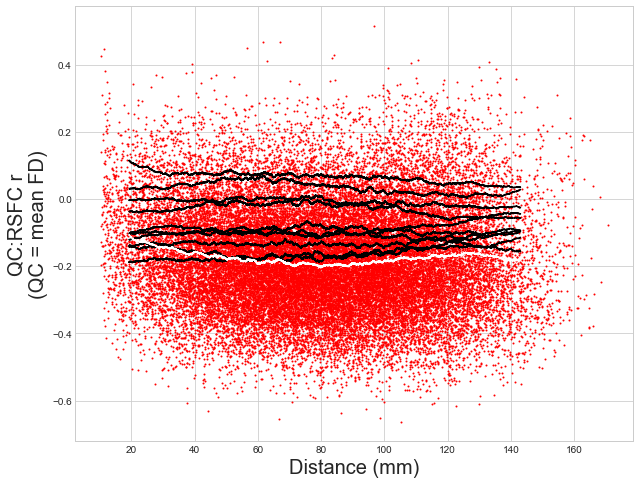

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(results['sorted_dists'], results['qcrsfc_y'],
            ax=ax, scatter=True, fit_reg=False,
            line_kws={'color': 'black', 'linewidth': 3},
            scatter_kws={'color': 'red', 's': 1., 'alpha': 1})
for i in range(10):
    ax.plot(results['sorted_dists'], results['qcrsfc_null'][i, :],
            color='black')
ax.plot(results['sorted_dists'], results['qcrsfc_smc'],
        color='white')
ax.set_xlabel('Distance (mm)', fontsize=20)
ax.set_ylabel('QC:RSFC r\n(QC = mean FD)', fontsize=20)
fig.show()

In [7]:
intercept = gp.get_val(results['sorted_dists'],
                       results['qcrsfc_smc'], v1)
slope = ((gp.get_val(results['sorted_dists'],
                     results['qcrsfc_smc'], v2) -
          gp.get_val(results['sorted_dists'],
                     results['qcrsfc_smc'], v1))
         / (v2 - v1))
perm_intercepts = gp.get_val(results['sorted_dists'],
                             results['qcrsfc_null'], v1)
perm_slopes = ((gp.get_val(results['sorted_dists'],
                           results['qcrsfc_null'], v2) -
                gp.get_val(results['sorted_dists'],
                           results['qcrsfc_null'], v1))
               / (v2 - v1))

p_inter = gp.rank_p(intercept, perm_intercepts, tail='upper')
p_slope = gp.rank_p(slope, perm_slopes, tail='upper')
print('Intercept = {0:.04f}, p = {1:.04f}'.format(intercept, p_inter))
print('Slope = {0:.04f}, p = {1:.04f}'.format(slope, p_slope))

Intercept = -0.1551, p = 0.9000
Slope = -0.0005, p = 0.9000


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


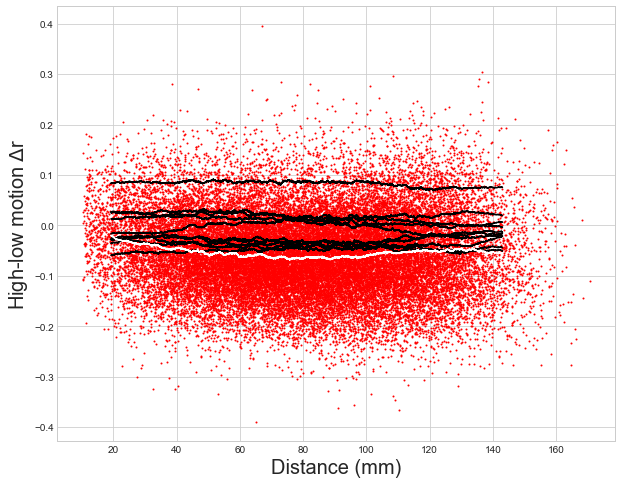

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(results['sorted_dists'], results['hl_y'],
            ax=ax, scatter=True, fit_reg=False,
            line_kws={'color': 'black', 'linewidth': 3},
            scatter_kws={'color': 'red', 's': 1, 'alpha': 1})
for i in range(10):
    ax.plot(results['sorted_dists'], results['hl_null'][i, :],
            color='black')
ax.plot(results['sorted_dists'], results['hl_smc'],
        color='white')
ax.set_xlabel('Distance (mm)', fontsize=20)
ax.set_ylabel(r'High-low motion $\Delta$r', fontsize=20)
fig.show()

In [9]:
intercept = gp.get_val(results['sorted_dists'],
                       results['hl_smc'], v1)
slope = ((gp.get_val(results['sorted_dists'],
                     results['hl_smc'], v2) -
          gp.get_val(results['sorted_dists'],
                     results['hl_smc'], v1))
         / (v2 - v1))
perm_intercepts = gp.get_val(results['sorted_dists'],
                             results['hl_null'], v1)
perm_slopes = ((gp.get_val(results['sorted_dists'],
                           results['hl_null'], v2) -
                gp.get_val(results['sorted_dists'],
                           results['hl_null'], v1))
               / (v2 - v1))

p_inter = gp.rank_p(intercept, perm_intercepts, tail='upper')
p_slope = gp.rank_p(slope, perm_slopes, tail='upper')
print('Intercept = {0:.04f}, p = {1:.04f}'.format(intercept, p_inter))
print('Slope = {0:.04f}, p = {1:.04f}'.format(slope, p_slope))

Intercept = -0.0432, p = 0.9000
Slope = -0.0003, p = 0.8000


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


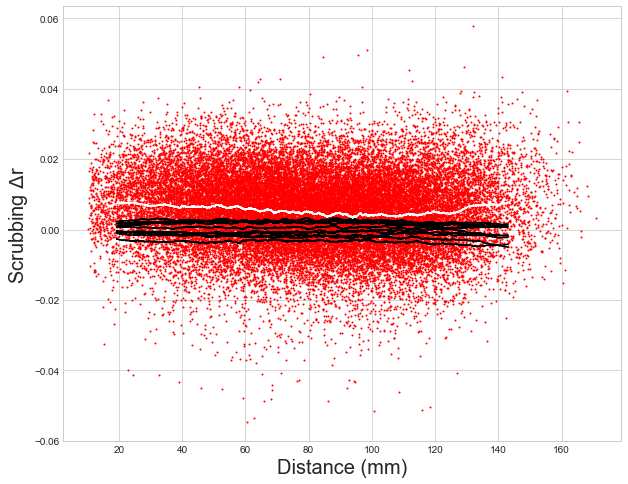

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(results['sorted_dists'], results['scrub_y'],
            ax=ax, scatter=True, fit_reg=False,
            line_kws={'color': 'black', 'linewidth': 3},
            scatter_kws={'color': 'red', 's': 1, 'alpha': 1})
for i in range(10):
    ax.plot(results['sorted_dists'], results['scrub_null'][i, :],
            color='black')
ax.plot(results['sorted_dists'], results['scrub_smc'],
        color='white')
ax.set_xlabel('Distance (mm)', fontsize=20)
ax.set_ylabel(r'Scrubbing $\Delta$r', fontsize=20)
fig.show()

In [11]:
intercept = gp.get_val(results['sorted_dists'],
                       results['scrub_smc'], v1)
slope = ((gp.get_val(results['sorted_dists'],
                     results['scrub_smc'], v2) -
          gp.get_val(results['sorted_dists'],
                     results['scrub_smc'], v1))
         / (v2 - v1))

perm_intercepts = gp.get_val(results['sorted_dists'],
                             results['scrub_null'], v1)
perm_slopes = ((gp.get_val(results['sorted_dists'],
                           results['scrub_null'], v2) -
                gp.get_val(results['sorted_dists'],
                           results['scrub_null'], v1))
               / (v2 - v1))
p_inter = gp.rank_p(intercept, perm_intercepts, tail='upper')
p_slope = gp.rank_p(slope, perm_slopes, tail='upper')
print('Intercept = {0:.04f}, p = {1:.04f}'.format(intercept, p_inter))
print('Slope = {0:.04f}, p = {1:.04f}'.format(slope, p_slope))

Intercept = 0.0069, p = 0.0000
Slope = -0.0000, p = 1.0000
